In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


If you are running this notebook in a binder instance, you need to install the ringdown package, so execute this cell:

In [ ]:
!pip install ringdown

In [3]:
import ringdown

# Data

## PSDs and ACFs

In [4]:
# simulate 2s of white Gaussian noise sampled at 8192 Hz

x = ringdown.Data(random.normal(0, 1, 16384),
                 ifo='H1', index=arange(16384)/8192)
x

0.000000    1.762589
0.000122    0.896274
0.000244   -1.047958
0.000366    0.336341
0.000488    0.559965
              ...   
1.999390    1.608664
1.999512    0.213264
1.999634    0.678495
1.999756   -1.337267
1.999878   -1.060091
Length: 16384, dtype: float64

In [5]:
# access some attributes
x.ifo, x.delta_t, x.duration, x.delta_f, x.fsamp

('H1', 0.0001220703125, 2.0, 0.5, 8192.0)

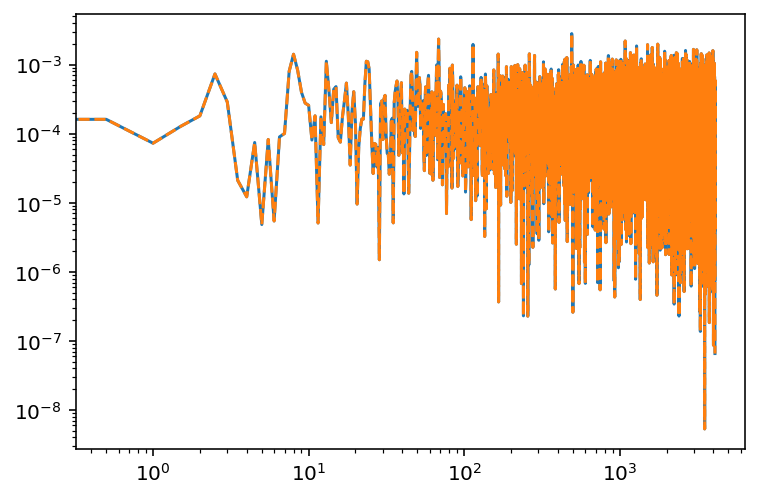

In [6]:
# get a PSD
p = x.get_psd(nperseg=len(x))

# this is the same as the Welch PSD
import scipy.signal as sig
freq, psd = sig.welch(x, fs=x.fsamp, nperseg=len(x))

loglog(p.freq, p)
loglog(freq, psd, ls='--')

In [7]:
# the PSD is a FrequencySeries with some attributes
p.delta_t, p.duration, p.delta_f, p.fsamp

(0.0001220703125, 1.0001220703125, 0.5, 8192.0)

In [8]:
# from the psd we can get an ACF
acf_fd = p.to_acf()
acf_fd

0.000000    1.001986
0.000122    0.029429
0.000244   -0.006870
0.000366   -0.010435
0.000488    0.002380
              ...   
1.999390   -0.004526
1.999512    0.002380
1.999634   -0.010435
1.999756   -0.006870
1.999878    0.029429
Length: 16384, dtype: float64

In [9]:
# or we could have produced this directly from the original data
x.get_acf(method='fd')

/Users/wfarr/miniconda3/envs/ringdown/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 49152 is greater than input length  = 16384, using nperseg = 16384
  warnings.warn('nperseg = {0:d} is greater than input length '


0.000000    1.001986
0.000122    0.029429
0.000244   -0.006870
0.000366   -0.010435
0.000488    0.002380
              ...   
1.999390   -0.004526
1.999512    0.002380
1.999634   -0.010435
1.999756   -0.006870
1.999878    0.029429
Length: 16384, dtype: float64

In [10]:
# the default method is through correlate
# (see documentation or code for all options)
acf_td = x.get_acf()
acf_td

0.000000    0.989846
0.000122    0.015513
0.000244   -0.001728
0.000366   -0.006418
0.000488   -0.006344
              ...   
1.999390    0.000078
1.999512    0.000124
1.999634    0.000068
1.999756   -0.000202
1.999878   -0.000114
Length: 16384, dtype: float64

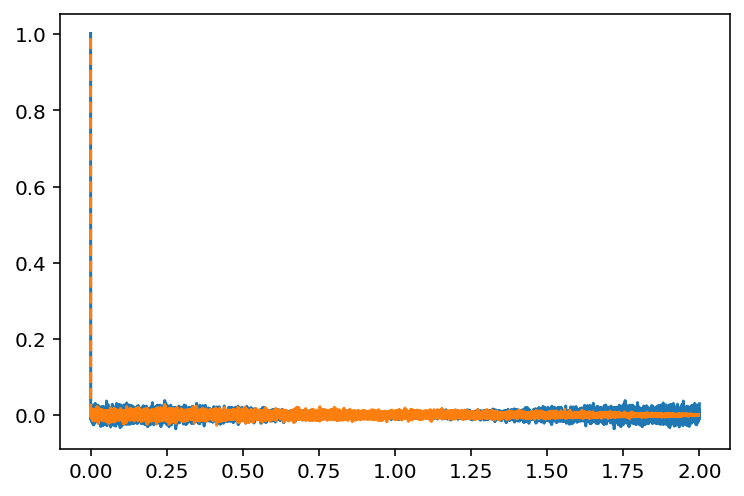

In [11]:
plot(acf_fd.time, acf_fd)
plot(acf_td.time, acf_td, ls='--')

In [ ]:
%time

# acfs objects know how to compute, and cache, the cholesky decomp 
# of their corresponding covariance matrix

acf_td.cholesky

In [13]:
%time
L = acf_td.cholesky

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


## Conditioning

In [12]:
# Data objects know how to return a conditioned copy of themselves

# highpass and downsample by 2, assume analysis time will be 1
x_cond = x.condition(flow=20, ds=2, t0=1)

# NOTE: condition takes a t0 argument specify a target time to be
# preserved after decimation by rolling

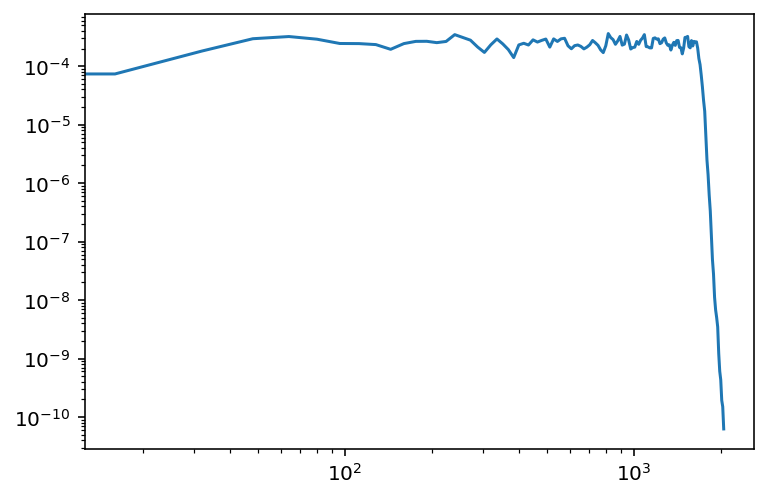

In [13]:
# look at the new psd (highpass won't be visible bc example seglen was too short)
p_cond = x_cond.get_psd()
loglog(p_cond.freq, p_cond)

In [14]:
# the conditioned data remember their identity
x_cond.ifo, x.ifo

('H1', 'H1')

# Fitting

## Frequency and damping

### setting prior and adding data

In [15]:
# let's create a fit object for a simple f-tau fit

# creating a Fit() object requires only the `model` key,
# others can be added later
# besides the `modes` kwarg, other arguments will be 
# passed to stan_data
f = ringdown.Fit(model='ftau', modes=2, A_max=0.5)

In [16]:
# we've created a model with 2 arbitrary modes
f.n_modes

2

In [17]:
# we've already specified we want the prior to allow ampltitudes
# up to A_max=0.5, we can check what other parameters we can set
f.valid_model_options

['A_scale', 'drift_scale', 'f_max', 'f_min', 'gamma_max', 'gamma_min']

In [18]:
# let's set the additional prior bounds we left out above
f.update_prior(A_scale=1E-21, f_min=100, f_max=500, gamma_min=100, gamma_max=500)

In [19]:
f.prior_settings

{'A_scale': 1e-21,
 'drift_scale': 0.0,
 'f_max': 500,
 'f_min': 100,
 'gamma_max': 500,
 'gamma_min': 100,
 'A_max': 0.5}

In [20]:
# let's add data to our Fit
f.add_data(x_cond, acf=acf_td)

In [21]:
f.data

{'H1': 0.500000    0.672845
 0.500244    0.318091
 0.500488   -0.267113
 0.500732   -0.159699
 0.500977   -0.837152
               ...   
 1.498779    0.857167
 1.499023    1.235548
 1.499268   -0.224959
 1.499512   -0.974141
 1.499756   -0.765184
 Length: 4096, dtype: float64}

In [22]:
f.acfs

{'H1': 0.000000    0.989846
 0.000122    0.015513
 0.000244   -0.001728
 0.000366   -0.006418
 0.000488   -0.006344
               ...   
 1.999390    0.000078
 1.999512    0.000124
 1.999634    0.000068
 1.999756   -0.000202
 1.999878   -0.000114
 Length: 16384, dtype: float64}

In [23]:
# if we hadn't provided an ACF to add data, we could have asked
# Fit to compute it automatically for all added IFOs
f.compute_acfs()

# calling compute_acfs rewrote the ACF we had added

# NOTE: compute_acfs takes `shared` boolean argument that specifices if all
# IFOs are to share a single ACF, in which case the ACF is only computed
# once from the data of the first IFO (useful for simulated data)

# it also accepts an `ifos` argument, giving specific IFOs for which to 
# compute ACF, otherwise computes it for all

In [24]:
# now let's set an analysis target
# for this model this is just a start time (no sky loc required)
# and optionally an analysis duration

# let's pick t0 in the middle of the segment
t0 = x.time[0] + 0.5*x.duration

# and pass a duration (in same unit as time array)
# --- also accept a number of samples instead.
f.set_target(t0, duration=0.02)

In [25]:
f.target

Target(t0=1.0, ra=None, dec=None, psi=None)

In [26]:
f.t0, f.duration, f.n_analyze

(1.0, 0.02, 82)

In [27]:
# the data are not truncated at this point
# the following function returns the right slice 
f.analysis_data

{'H1': 1.000000   -0.053259
 1.000244   -0.772811
 1.000488   -1.035620
 1.000732   -0.030852
 1.000977   -0.119588
               ...   
 1.018799    0.125638
 1.019043   -0.138995
 1.019287    0.272676
 1.019531   -0.806613
 1.019775   -0.918147
 Length: 82, dtype: float64}

In [28]:
# we can get the index of the first analysis sample in the big segment
# corresponding to the analysis time (closest to t0)
f.start_indices

{'H1': 2048}

In [29]:
f.start_times

{'H1': 1.0}

In [30]:
f.data['H1'].time[f.start_indices['H1']]

1.0

### Compiling and fitting

In [31]:
# so far the Stan model hasn't compiled
# this will happen automatically the first time we run
# otherwise, we can force this to happen by calling compile()

f.compile()

ld: warning: -pie being ignored. It is only used when linking a main executable


In [32]:
# note this won't be recompile unless we use the force argument
f.compile()

In [33]:
ringdown.MODELS

('ftau', 'mchi', 'mchi_aligned')

In [34]:
ringdown.fit.MODELS

('ftau', 'mchi', 'mchi_aligned')

In [35]:
# to run the model all we need to do is call run()
# kwargs will be interpreted as stan run time settings (number of chains etc)
# the model won't be compiled again since we already compiled it above
# (and this would be true for other instance of Fit with the ftau model in 
# the same session)
f.run()

Running ftau

Gradient evaluation took 0.001271 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001267 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.67 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.001283 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.83 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.001216 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.16 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iterati

Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 114.951 seconds (Warm-up)
               80.6632 seconds (Sampling)
               195.615 seconds (Total)



In [36]:
# the result has been saved within the Fit object itself
f.result

Inference data with groups:
	> posterior
	> sample_stats

In [37]:
# we could've also done a prior-only run
f.run(prior=True)

Running ftau

Gradient evaluation took 0.000278 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.78 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000351 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000275 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.75 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000257 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.57 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration: 

Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 13.0794 seconds (Warm-up)
               6.40856 seconds (Sampling)
               19.488 seconds (Total)



In [38]:
# the result is saved in prior
f.prior

Inference data with groups:
	> posterior
	> sample_stats

## Mass and spin

### setting prior and adding data

In [39]:
# the mass and spin fit works much in the same way

f2 = ringdown.Fit(model='mchi', A_scale=0.5)

In [40]:
# this time, we didn't add modes above, instead let's set 
# the modes to be a sequence of overtones (by default 22 mode, prograde)

# requesting 2 modes implies an N=1 fit (fundamental + overtone)
f2.set_tone_sequence(2)

In [41]:
# we can check that the modes have been added correctly
f2.modes

[ModeIndex(p=1, s=-2, l=2, m=2, n=0), ModeIndex(p=1, s=-2, l=2, m=2, n=1)]

In [42]:
# NOTE: the p index is +1 for prograde, and -1 for retrograde modes
# we could have equivalently passed `modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)]`
# when creating the Fit instance, or used its set_modes method with the same argument

In [43]:
# we've already specified we want the prior to allow amplitudes
# up to A_max=0.5, we can check what other parameters we can set
f2.valid_model_options

['A_scale',
 'drift_scale',
 'perturb_f',
 'perturb_tau',
 'df_max',
 'dtau_max',
 'M_min',
 'M_max',
 'chi_min',
 'chi_max',
 'flat_A_ellip']

In [44]:
# let's set some additional prior bounds, for the others we'll use the default
f2.update_prior(M_min=50, M_max=100)

f2.prior_settings

{'A_scale': 0.5,
 'drift_scale': 0.0,
 'perturb_f': array([0., 0.]),
 'perturb_tau': array([0., 0.]),
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 50,
 'M_max': 100,
 'chi_min': 0,
 'chi_max': 0.99,
 'flat_A_ellip': 0}

In [45]:
# let's add data to our Fit
f2.add_data(x_cond)

# let's add a second IFO (cheating by just duplicating the same data)
y_cond = x_cond.copy()
y_cond.ifo = 'L1'

f2.add_data(y_cond)

In [46]:
f2.data

{'H1': 0.500000    0.672845
 0.500244    0.318091
 0.500488   -0.267113
 0.500732   -0.159699
 0.500977   -0.837152
               ...   
 1.498779    0.857167
 1.499023    1.235548
 1.499268   -0.224959
 1.499512   -0.974141
 1.499756   -0.765184
 Length: 4096, dtype: float64,
 'L1': 0.500000    0.672845
 0.500244    0.318091
 0.500488   -0.267113
 0.500732   -0.159699
 0.500977   -0.837152
               ...   
 1.498779    0.857167
 1.499023    1.235548
 1.499268   -0.224959
 1.499512   -0.974141
 1.499756   -0.765184
 Length: 4096, dtype: float64}

In [47]:
f2.ifos

['H1', 'L1']

In [48]:
# we haven't added any ACFs
f2.acfs

{}

In [49]:
# let's compute ACFs for all IFOs, but let's tell Fit
# that they all share a single ACF
f2.compute_acfs(shared=True)

f2.acfs

{'H1': 0.000000    0.421044
 0.000244    0.075527
 0.000488   -0.079323
 0.000732    0.054180
 0.000977   -0.030665
               ...   
 0.998779    0.000446
 0.999023    0.000279
 0.999268   -0.000063
 0.999512   -0.000219
 0.999756   -0.000126
 Length: 4096, dtype: float64,
 'L1': 0.000000    0.421044
 0.000244    0.075527
 0.000488   -0.079323
 0.000732    0.054180
 0.000977   -0.030665
               ...   
 0.998779    0.000446
 0.999023    0.000279
 0.999268   -0.000063
 0.999512   -0.000219
 0.999756   -0.000126
 Length: 4096, dtype: float64}

In [50]:
# now let's set an analysis target this time with a sky location

# let's pick t0 in the middle of the segment
# now the truncation time will be defined to be at geocenter
t0 = x.time[0] + 0.5*x.duration

# and pass a duration (in same unit as time array)
# --- also accept a number of samples instead.
f2.set_target(t0, 1.92, 0.8, 0, duration=0.02)

In [51]:
f2.target

Target(t0=1.0, ra=1.92, dec=0.8, psi=0)

In [52]:
f2.has_target

True

In [53]:
f2.t0, f.duration, f.n_analyze

(1.0, 0.02, 82)

In [54]:
# the target allows the fit to compute antenna patterns
f2.antenna_patterns

{'H1': [0.27314198380407506, -0.36414750450706745],
 'L1': [0.023415325210703053, 0.41321163714139464]}

In [55]:
# the data are not truncated at this point
# the following function returns the right slice 
# NOTE: the sky location is automatically taken into account
# so note the tart times are different
f2.analysis_data

{'H1': 0.994873    0.044767
 0.995117    0.499463
 0.995361    0.367342
 0.995605    0.109231
 0.995850   -0.280849
               ...   
 1.013672   -0.463428
 1.013916    0.959738
 1.014160    0.523688
 1.014404   -0.478709
 1.014648    0.964025
 Length: 82, dtype: float64,
 'L1': 0.993652   -0.194646
 0.993896   -0.374804
 0.994141   -1.324496
 0.994385   -0.149457
 0.994629    0.010235
               ...   
 1.012451   -0.509741
 1.012695    0.006536
 1.012939   -0.249901
 1.013184   -0.152512
 1.013428    0.394680
 Length: 82, dtype: float64}

In [56]:
# we can get the index of the first analysis sample in the big segment
# corresponding to the analysis time (closest to t0)
f2.start_indices

{'H1': 2027, 'L1': 2022}

In [57]:
f2.start_times

{'H1': 0.9948112141035089, 'L1': 0.9936281071692268}

In [58]:
f2.data['H1'].time[f2.start_indices['H1']]

0.994873046875

### Compiling and fitting

In [59]:
# the rest is the same as above
# the kerr model internally takes care of f,tau fit coefficients

In [60]:
# to run the model all we need to do is call run()
# kwargs will be interpreted as stan run time settings (number of chains etc)
# the model will be compiled now since we didn't manually compile it before
f2.run()

Running mchi


ld: warning: -pie being ignored. It is only used when linking a main executable



Gradient evaluation took 0.00263 seconds

1000 transitions using 10 leapfrog steps per transition would take 26.3 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.002871 seconds
1000 transitions using 10 leapfrog steps per transition would take 28.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.002791 seconds
1000 transitions using 10 leapfrog steps per transition would take 27.91 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00265 seconds
1000 transitions using 10 leapfrog steps per transition would take 26.5 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [

Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 27.3082 seconds (Warm-up)
               20.4118 seconds (Sampling)
               47.72 seconds (Total)



In [61]:
# the result has been saved within the Fit object itself
f2.result

Inference data with groups:
	> posterior
	> sample_stats

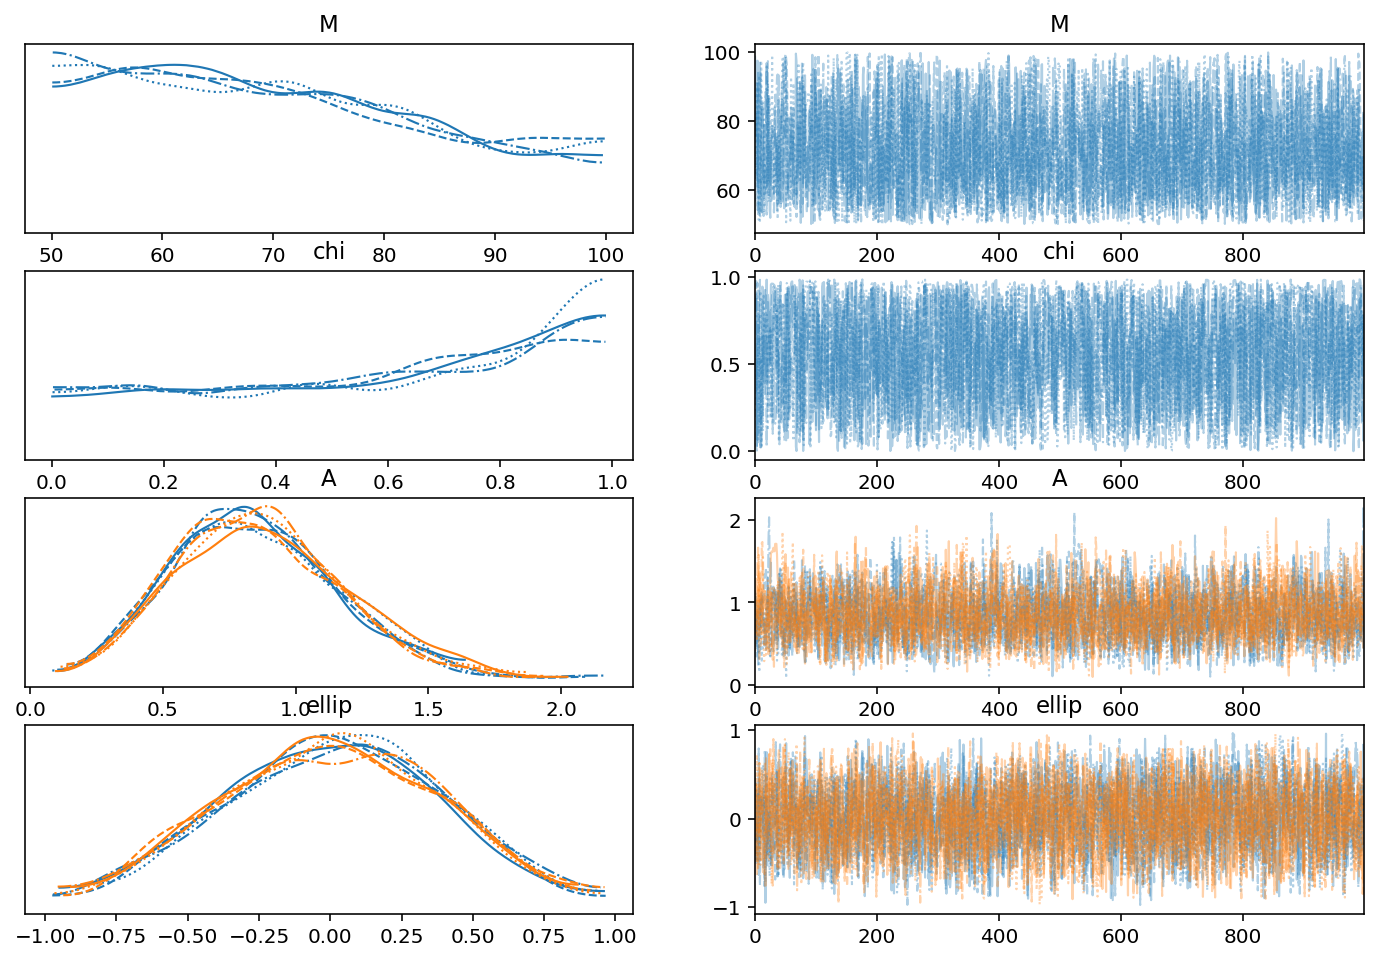

In [62]:
# of course the result is nonsense because there was no signal in the data

import arviz as az
az.plot_trace(f2.result, var_names=['M', 'chi', 'A', 'ellip']);

In [63]:
# we could've also done a prior-only run
f2.run(prior=True)

Running mchi

Gradient evaluation took 0.000143 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.43 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000115 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000104 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.04 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 9.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.97 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  

In [64]:
# the result is saved in prior
f2.prior

Inference data with groups:
	> posterior
	> sample_stats

/Users/wfarr/miniconda3/envs/ringdown/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/wfarr/miniconda3/envs/ringdown/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/wfarr/miniconda3/envs/ringdown/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/wfarr/miniconda3/envs/ringdown/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no 

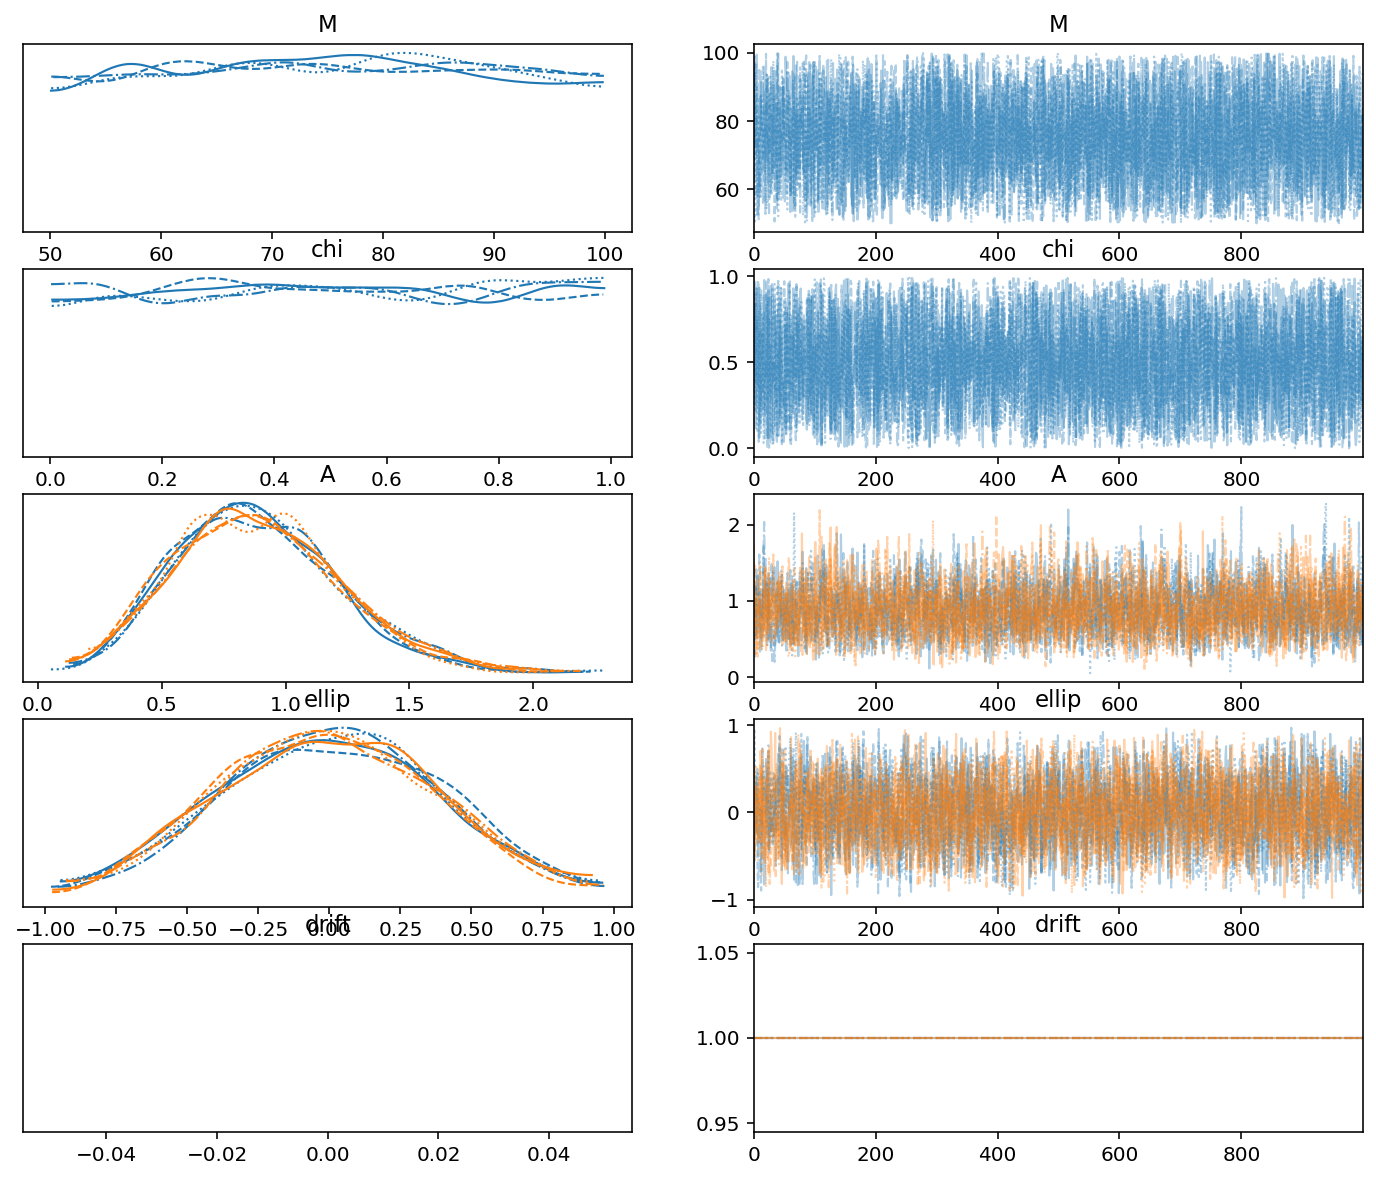

In [65]:
# of course the result is nonsense because there was no signal in the data

import arviz as az
az.plot_trace(f2.prior, var_names=['M', 'chi', 'A', 'ellip', 'drift']);

In [66]:
# we can check what input was passed to stan by calling
# (could've also done this before running / compiling)

# f2.model_input

#### Frequency-damping fits

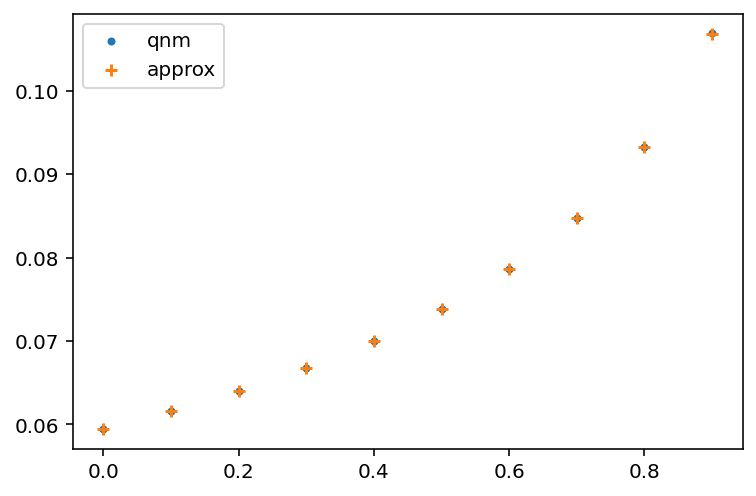

In [67]:
# we can check the approximations used in the Kerr fit
# let's look at the fundamental

mode = ringdown.qnms.KerrMode(f2.modes[0])

chis = linspace(0, 1, 10, endpoint=False)
scatter(chis, mode.ftau(chis)[0], marker='.', label='qnm')
scatter(chis, mode.ftau(chis, approx=True)[0], marker='+', label='approx')
legend();

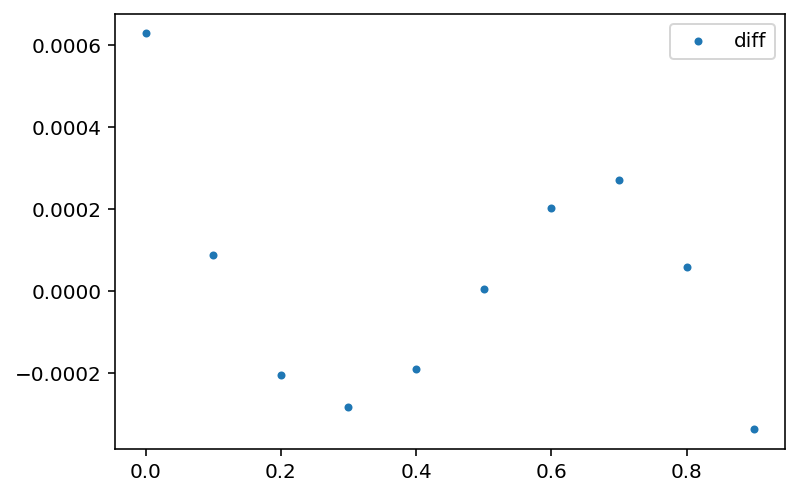

In [68]:
# we can check the approximations used in the Kerr fit
# let's look at the fundamental

mode = ringdown.qnms.KerrMode(f2.modes[0])

chis = linspace(0, 1, 10, endpoint=False)
scatter(chis, (mode.ftau(chis, approx=True)[0] - mode.ftau(chis)[0])/mode.ftau(chis, approx=True)[0], marker='.', label='diff')
legend();